In [1]:
import glob
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import keras
import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Activation, Input, Dense, Conv2D, Conv2DTranspose, Dropout, LeakyReLU
from keras.regularizers import l1
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TerminateOnNaN, TensorBoard

Using TensorFlow backend.


# Define utility and training functions

In [3]:
def get_dimensions(files):
    min_height, min_width = 10000, 10000
    max_height, max_width = 0, 0
    for f in files:
        img = cv.imread(f)
        h,w = img.shape[:2]
        if h < min_height:
            min_height = h
        if h > max_height:
            max_height = h
        if w < min_width:
            min_width = w
        if w > max_width:
            max_width = w
    return min_height, min_width, max_height, max_width

def make_train_val(files):
    num_files = len(files)
    train = files[:int(.6*num_files)]
    val = files[int(.6*num_files):]
    return train, val

def get_batches(files, batch_size, resize_size):
    count = 0
    batch_out = np.zeros((batch_size, resize_size[0], resize_size[1], 3), dtype=np.uint8)
    num_files = len(files)
    while True:
        f = files[count%num_files]
        img = cv.imread(f)
        res = cv.resize(img, resize_size)
        batch_out[count%batch_size,...] = res
        count += 1
        if count%batch_size == 0:
            yield batch_out.astype(np.float)/255., batch_out.astype(np.float)/255.
            
# Autoencoder based on convolution and deconvolution
class autoencoder_conv():
    def __init__(self,
                 input_shape,
                 n_enc_conv_layers=2, # each layer is followed by a Pooling layer
                 n_enc_conv_filters=[32]*2, # individually customizable
                 enc_kernel_size=[(3,2)]*2, # list of integers or tuples
                 n_dec_conv_filters=[32]*2,
                 dec_kernel_size=[(3,2)]*2,
                 dropout=[0.0]*4, # individually customizable
                 strides=[(2,1)]*2,
                 activation='relu',
                 kernel_initializer='glorot_uniform',
                 l1_reg=0.0,
                 lr=0.001
                ):

        if len(n_enc_conv_filters) == 1:
            n_enc_conv_filters = n_enc_conv_filters*n_enc_conv_layers

        if len(enc_kernel_size) == 1:
            enc_kernel_size = enc_kernel_size*n_enc_conv_layers

        if len(n_dec_conv_filters) == 1:
            n_dec_conv_filters = n_dec_conv_filters*n_enc_conv_layers

        if len(dec_kernel_size) == 1:
            dec_kernel_size = dec_kernel_size*n_enc_conv_layers

        if len(dropout) == 1:
            dropout = dropout*(2*n_enc_conv_layers)

        if len(strides) == 1:
            strides = strides*n_enc_conv_layers

        self.input_shape=input_shape
        self.n_enc_conv_layers=n_enc_conv_layers
        self.n_enc_conv_filters=n_enc_conv_filters
        self.enc_kernel_size=enc_kernel_size
        self.n_dec_conv_filters=n_dec_conv_filters
        self.dec_kernel_size=dec_kernel_size
        self.dropout=dropout
        self.strides=strides
        self.activation=activation
        self.kernel_initializer = kernel_initializer
        self.l1_reg=l1_reg
        self.lr=lr
        self.model = self.get_model()

    def get_model(self):
        I = Input(shape=self.input_shape, name='input')
        # start encoder
        E_in = I
        for i in range(self.n_enc_conv_layers):
            E_in = Conv2D(self.n_enc_conv_filters[i], self.enc_kernel_size[i], strides=self.strides[i], padding='same',
                            data_format='channels_last', kernel_initializer=self.kernel_initializer,
                            kernel_regularizer=l1(self.l1_reg), name='encoder_{}'.format(i))(E_in)
            if self.activation == 'LeakyReLU':
                E_in = LeakyReLU()(E_in)
            else:
                E_in = Activation(self.activation)(E_in)
            E_in = Dropout(self.dropout[i])(E_in)
        
        # start decoder
        D_in = E_in
        for i in range(self.n_enc_conv_layers-1):
            D_in = Conv2DTranspose(self.n_dec_conv_filters[i], self.dec_kernel_size[i], strides=self.strides[-1-i], padding='same',
                             data_format='channels_last', kernel_initializer=self.kernel_initializer,
                             kernel_regularizer=l1(self.l1_reg))(D_in)
            if self.activation == 'LeakyReLU':
                D_in = LeakyReLU()(D_in)
            else:
                D_in = Activation(self.activation)(D_in)
            D_in = Dropout(self.dropout[i])(D_in)

        O = Conv2D(3, (3,3), padding='same', data_format='channels_last',
                         activation='sigmoid', kernel_initializer=self.kernel_initializer,
                         kernel_regularizer=l1(self.l1_reg), name='output')(D_in)
        
        model = Model(inputs=I, outputs=O)
        model.compile(loss='binary_crossentropy', optimizer=Adam(lr=self.lr), metrics=['mse'])
        return model
    
def train(train_files, val_files, epochs=100, batch_size=8, common_size=(128,128), new_model=True, save_model_name='model_1.hdf5'):
    num_batches_per_epoch = len(train_files)//batch_size
    
    train_batch_generator = get_batches(train_files, batch_size, common_size)
    val_batch_generator = get_batches(val_files, batch_size, common_size)

    checkpt = ModelCheckpoint(save_model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    
    if new_model: # create a new model
        model = autoencoder_conv([common_size[0], common_size[1], 3],
                                 n_enc_conv_layers=12,
                                 n_enc_conv_filters=[64]*12,
                                 enc_kernel_size=[(3,3)],
                                 n_dec_conv_filters=[64]*11,
                                 dec_kernel_size=[(3,3)],
                                 dropout=[0.0],
                                 strides=([(1,1)]*2+[(2,2)])*4,
                                 activation='relu',
                                 kernel_initializer='glorot_uniform',
                                 l1_reg=0.0,
                                 lr=0.0001).model
    else: # continue to train a previous model
        print('Continuing training from a previous model')
        model = load_model('models/'+save_model_name)

    model.summary()
    model.fit_generator(train_batch_generator, steps_per_epoch=num_batches_per_epoch, epochs=epochs,
                        verbose=1, callbacks=[checkpt, TerminateOnNaN(), TensorBoard(log_dir='/tmp/autoencoder')], 
                        validation_data=val_batch_generator, validation_steps=100)
    return model

In [6]:
imgs = glob.glob('Images\\12242018_to_12251028\\*.jpg')
# min_h, min_w, max_h, max_w = get_dimensions(imgs)
# print('Minimum height = {}, minimum width = {}, maximum height = {}, maximum width = {}'.format(min_h, min_w, max_h, max_w))
train_files, val_files = make_train_val(imgs)
model = train(train_files[:128], val_files[:128], epochs=100, batch_size=8, new_model=False, save_model_name='model_1.hdf5')

Continuing training from a previous model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 128, 128, 3)       0         
_________________________________________________________________
encoder_0 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
activation_59 (Activation)   (None, 128, 128, 64)      0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 128, 128, 64)      0         
_________________________________________________________________
encoder_1 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
activation_60 (Activation)   (None, 128, 128, 64)      0         
_________________________________________________________________
dropout_60 (Dropout)         (None

Epoch 1/100
16/16 [==============================] - 13s 810ms/step - loss: 0.2158 - mean_squared_error: 0.0016 - val_loss: 0.2177 - val_mean_squared_error: 0.0017

Epoch 00001: val_loss improved from inf to 0.21767, saving model to model_1.hdf5
Epoch 2/100
16/16 [==============================] - 12s 779ms/step - loss: 0.2156 - mean_squared_error: 0.0016 - val_loss: 0.2172 - val_mean_squared_error: 0.0017

Epoch 00002: val_loss improved from 0.21767 to 0.21720, saving model to model_1.hdf5
Epoch 3/100
16/16 [==============================] - 12s 779ms/step - loss: 0.2155 - mean_squared_error: 0.0016 - val_loss: 0.2171 - val_mean_squared_error: 0.0017

Epoch 00003: val_loss improved from 0.21720 to 0.21705, saving model to model_1.hdf5
Epoch 4/100
16/16 [==============================] - 12s 779ms/step - loss: 0.2154 - mean_squared_error: 0.0016 - val_loss: 0.2169 - val_mean_squared_error: 0.0017

Epoch 00004: val_loss improved from 0.21705 to 0.21689, saving model to model_1.hdf5
Epoc


Epoch 00036: val_loss improved from 0.21325 to 0.21309, saving model to model_1.hdf5
Epoch 37/100
16/16 [==============================] - 12s 779ms/step - loss: 0.2115 - mean_squared_error: 0.0016 - val_loss: 0.2131 - val_mean_squared_error: 0.0017

Epoch 00037: val_loss did not improve
Epoch 38/100
16/16 [==============================] - 12s 780ms/step - loss: 0.2114 - mean_squared_error: 0.0016 - val_loss: 0.2131 - val_mean_squared_error: 0.0017

Epoch 00038: val_loss did not improve
Epoch 39/100
16/16 [==============================] - 13s 788ms/step - loss: 0.2112 - mean_squared_error: 0.0016 - val_loss: 0.2125 - val_mean_squared_error: 0.0017

Epoch 00039: val_loss improved from 0.21309 to 0.21252, saving model to model_1.hdf5
Epoch 40/100
16/16 [==============================] - 13s 789ms/step - loss: 0.2111 - mean_squared_error: 0.0016 - val_loss: 0.2127 - val_mean_squared_error: 0.0017

Epoch 00040: val_loss did not improve
Epoch 41/100
16/16 [==============================]

16/16 [==============================] - 13s 814ms/step - loss: 0.2075 - mean_squared_error: 0.0016 - val_loss: 0.2094 - val_mean_squared_error: 0.0016

Epoch 00073: val_loss did not improve
Epoch 74/100
16/16 [==============================] - 13s 806ms/step - loss: 0.2074 - mean_squared_error: 0.0016 - val_loss: 0.2089 - val_mean_squared_error: 0.0016

Epoch 00074: val_loss improved from 0.20896 to 0.20893, saving model to model_1.hdf5
Epoch 75/100
16/16 [==============================] - 12s 781ms/step - loss: 0.2073 - mean_squared_error: 0.0016 - val_loss: 0.2088 - val_mean_squared_error: 0.0016

Epoch 00075: val_loss improved from 0.20893 to 0.20880, saving model to model_1.hdf5
Epoch 76/100
16/16 [==============================] - 13s 785ms/step - loss: 0.2072 - mean_squared_error: 0.0016 - val_loss: 0.2087 - val_mean_squared_error: 0.0016

Epoch 00076: val_loss improved from 0.20880 to 0.20865, saving model to model_1.hdf5
Epoch 77/100
16/16 [==============================] - 13

(10, 128, 128, 3)
(10, 128, 128, 3)


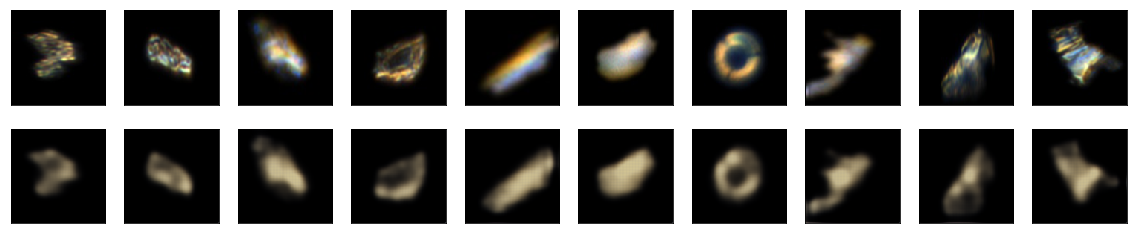

In [7]:
g = get_batches(train_files, 10, (128,128))
x_test, _ = next(g)
decoded_imgs = model.predict(x_test)

print(x_test.shape)
print(decoded_imgs.shape)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(np.uint8(x_test[i,...,::-1]*255))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(np.uint8(decoded_imgs[i,...,::-1]*255))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [82]:
print(np.uint8((x_test[0,50:100,50:100,0]-x_test[0,50:100,50:100,2])*255))

[[246 246 244 ...   0   0   0]
 [244 244 243 ...   0   0   0]
 [242 240 240 ... 255   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [83]:
print(np.uint8((decoded_imgs[0,50:100,50:100,0]-decoded_imgs[0,50:100,50:100,2])*255))

[[244 244 243 ... 255 255   0]
 [244 244 244 ... 255 255   0]
 [244 244 244 ... 254 254 255]
 ...
 [255 255 255 ...   0   0   0]
 [255   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [65]:
print(decoded_imgs.shape)

(10, 128, 128, 3)


In [5]:
imgs = glob.glob('Images\\12242018_to_12251028\\*.jpg')
train_files, val_files = make_train_val(imgs)
g = get_batches(train_files, 10, (128,128))
x_test, _ = next(g)

model = load_model('model_1.hdf5')
encoder = Model(inputs=model.input, outputs=model.get_layer('encoder_14').output)
encoded = encoder.predict(x_test)
print(encoded.shape)

(10, 4, 4, 32)


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
encoder_0 (Conv2D)           (None, 128, 128, 128)     3584      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 128)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 128)     0         
_________________________________________________________________
encoder_1 (Conv2D)           (None, 128, 128, 128)     147584    
_________________________________________________________________
activation_2 (Activation)    (None, 128, 128, 128)     0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 128, 128)     0         
__________